# Predicting Loan Status Based on Applicant Income and Loan Amount

## Introduction

### Background Information

Applying for a loan can be a tiring, extensive process. Many variables can affect one's loan approval status, and it is hard to determine which one is more significant for a successful application. 

Knowing what to look for in a when applying for a loan application is essential, given that rejection for a loan can affect credit score thus making it even more difficult to successfully acquire loans in the future. 

To aid in facilitating this common problem, this project aims to answer the following question: 

>*"Is it possible to determine loan approval status based on household income (co-applicant and applicant income), loan term, and loan amount?."*

### Dataset Description

To answer the proposed question, the dataset `loan_data.csv` will be used. Our dataset contains information on several loan applicants and was sourced from Kaggle. The dataset contains 13 columns and 381 rows, each of which represent a unique observation (i.e a loan application). Each column in the dataset represents the following:


| Variable             | Description                                                                   |
|----------------------|-------------------------------------------------------------------------------|
| `Loan_ID`            | A unique loan ID                                                              |
| `Gender`             | applicant gender, being male or female.                                       |
| `Married`            | applican marital status, being married (yes) or not married (no).             |
| `Dependents`         | Number of persons depending on the applicant.                                 |
| `Education`          | Applicant Education, being graduate or undergraduate.                         |
| `Self_Employed`      | If applicant is self-employed, options being yes or no.                       |
| `ApplicantIncome`    | Applicant income in dollars.                                                  |
| `CoapplicantIncome`  | Co-applicant income in dollars.                                               |
| `LoanAmount`         | Loan amount in thousands of dollars.                                          |
| `Loan_Amount_Term`   | Terms of the loan in months.                                                  |
| `Credit_History`     | if applicant's credit history meets guidelines.                               |
| `Property_Area`      | If applicants are living in urban, semi-Urban or rural setting.               |
| `Loan_Status`        | Loan approved, options being yes or no.                                       |

*<p><center> Figure 1.0: Variables and Description </center></p>*

## Methods and results

**Source:** https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction

In [1]:
## Required packages and versions
install.packages("gridExtra")
library(gridExtra)
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows
set.seed(2024)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip   

NOTE: The `themis` package needs to be installed since we are using the `step_upsample()` function provided in that package.

### Preliminary Exploratory Data Analysis

#### 1. Load the Original Dataset

In [2]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### **Table 0: Original Dataset**

In [3]:
loan_data

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LP002978,Female,No,0,Graduate,No,2900,0,71,360,1,Rural,Y
LP002979,Male,Yes,3+,Graduate,No,4106,0,40,180,1,Rural,Y
LP002990,Female,No,0,Graduate,Yes,4583,0,133,360,0,Semiurban,N


*<p><center> Figure 1.1: Original Dataset </center></p>*

##### **Table 1: Untidy `loan_data`**

As shown in Figure 1.1, the dataset is very large. There are too many rows for us to examine. We can pinpoint exactly how many rows there are using the function `nrow()`

In [4]:
nrow(loan_data)

[1] 381

Because of the large volume of observations, the `head()` function will be used to get an overview of the dataset. The first 6 rows of the original dataset `loan_data` are shown below in Figure 1.2.

In [5]:
head(loan_data)

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y
LP001024,Male,Yes,2,Graduate,No,3200,700,70,360,1,Urban,Y


*<p><center> Figure 1.2: Sliced Loan Data </center></p>*

From the original dataset table above, a few problems can be noticed, which will be addressed in the data cleaning process:

1. The column `Loan_Status` is not stored as a categorical variable.
2. There is no variable for the total income amount of the applicant's household.
3. There are rows with missing values.
4. Some of the column names are not standardized. Some spaces are separated with underscores, such as `Self_Employed`, some with capital letters, such as `LoanAmount`.

### 2. Data wrangling and cleaning

To tidy up our data, the following steps were followed:

1. Used the `mutate` and `as_factor` functions to change column `Loan_Status` to a categorical variable.
2. Use the `drop_na()` function to drop rows containing missing values.
3. Standardize the column names by assigning the new column names to a vector and passing it to the `colnames` function.

In [6]:
# clean the dataset accordingly
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

loan_data <- loan_data |> 
    mutate(Loan_Status = as_factor(Loan_Status)) |>
    drop_na() |>
    select(-Loan_ID, -Gender, -Married, -Property_Area)

# Standardising column names
colnames(loan_data) <- c("Dependents", "Education", "SelfEmployed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanTerm", "CreditHistory", "LoanStatus")

head(loan_data)

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Graduate,No,4583,1508,128,360,1,N
0,Graduate,Yes,3000,0,66,360,1,Y
0,Not Graduate,No,2583,2358,120,360,1,Y
0,Graduate,No,6000,0,141,360,1,Y
0,Not Graduate,No,2333,1516,95,360,1,Y
2,Graduate,No,3200,700,70,360,1,Y


*<p><center> Figure 2.0: Tidied Loan Data </center></p>*


As seen in figure 2.0, there are significantly (~48%) more positive classes (LoanStatus == Y) than negative classes. This class imbalance could lead to worse performance in the classifier. Hence, this is definitely something that should be dealt with when creating the model.

Similar to Figure 1.1, there are far too many observations to properly examine the data. The `head()` function will again be used to see the tidied data more clearly.

In [7]:
head(loan_data)

Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Graduate,No,4583,1508,128,360,1,N
0,Graduate,Yes,3000,0,66,360,1,Y
0,Not Graduate,No,2583,2358,120,360,1,Y
0,Graduate,No,6000,0,141,360,1,Y
0,Not Graduate,No,2333,1516,95,360,1,Y
2,Graduate,No,3200,700,70,360,1,Y


*<p><center> Figure 2.1: Sliced and Tidied Loan Data </center></p>*

### 3. Initial Split and Training Data Summary Tables for `loan_data`

We must first split the data `loan_split` using the function `initial_split`.

>Since the goal is to predict loan status, the strata is set to the variable `LoanStatus`. And the proportion of the dataset allocated to training data is 0.75.

Then, we divide it into training data, `loan_train`, and testing data, `loan_test` using the functions `training()` and `testing()`.

In [8]:
loan_split <- initial_split(loan_data, prop = 0.75, strata = LoanStatus)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

##### **Table 3: Training Dataset**

Using the `head()` function, the first 6 rows of the training data can be examined.

In [9]:
head(loan_train)

Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Graduate,No,4583,1508,128,360,1,N
0,Graduate,No,3510,0,76,360,0,N
0,Not Graduate,No,4887,0,133,360,1,N
0,Not Graduate,No,7660,0,104,360,0,N
0,Not Graduate,No,2600,1911,116,360,0,N
0,Not Graduate,No,1442,0,35,360,1,N


*<p><center> Figure 3.0: Training Data for Loan Status </center></p>*

It is necessary to analyze the relationship between variables in the training data set and loan status. So, a summary table is created with mean applicant income, mean co-applicant income, mean loan amount and mean loan term that generates a yes or a no for loan status.

In [10]:
loan_train_summary <- loan_train |>
    group_by(LoanStatus) |>
    summarize(Count = n(), MeanApplicantIncome = mean(ApplicantIncome), MeanCoapplicantIncome = mean(CoapplicantIncome), MeanLoanAmount = mean(LoanAmount), MeanLoanTerm = mean(LoanTerm))

##### **Table 4: Training Dataset Summary**

In [11]:
loan_train_summary

LoanStatus,Count,MeanApplicantIncome,MeanCoapplicantIncome,MeanLoanAmount,MeanLoanTerm
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
N,66,3417.439,1437.970,100.1667,345.0909
Y,164,3638.348,1215.457,104.1646,340.7561


*<p><center> Figure 3.1: Summary of Loan Data </center></p>*

With Figure 3.1, it is possible to notice that the mean applicant income for a "yes" loan status is significantly higher than that of a "no" loan status. This suggest that this may be a very strong predictor for loan status (i.e someone with a higher income might get a yes independently of other variables). This can also be noticed by the other variables: a "yes" loan status has a lower mean co-applicant income, higher mean loan amount and smaller loan term. This once again suggests that the main predictor might be mean applicant income. 

Still, it is important to note that these results might be due to the class imbalance mentioned earlier. Thus, it makes it extremely important to have a visualization of data in order to see the relationship between each one and loan status and also its distribution. With a scatter plot, for instance, it is possible to see if a medium to high income with a longer loan term is better that a very high income and a shorter loan term. 

### 4. Preliminary visualization of data

#### 4.1. Distribution of key predictors

**Predictor Distributions:** It is necessary to visualize the distribution of the possible predictors (`ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, and `LoanTerm`) to gather more information on the data set and better understand the implications of their usage in the knn algorithm. To do so, it is necessary to create 4 density plot histograms.

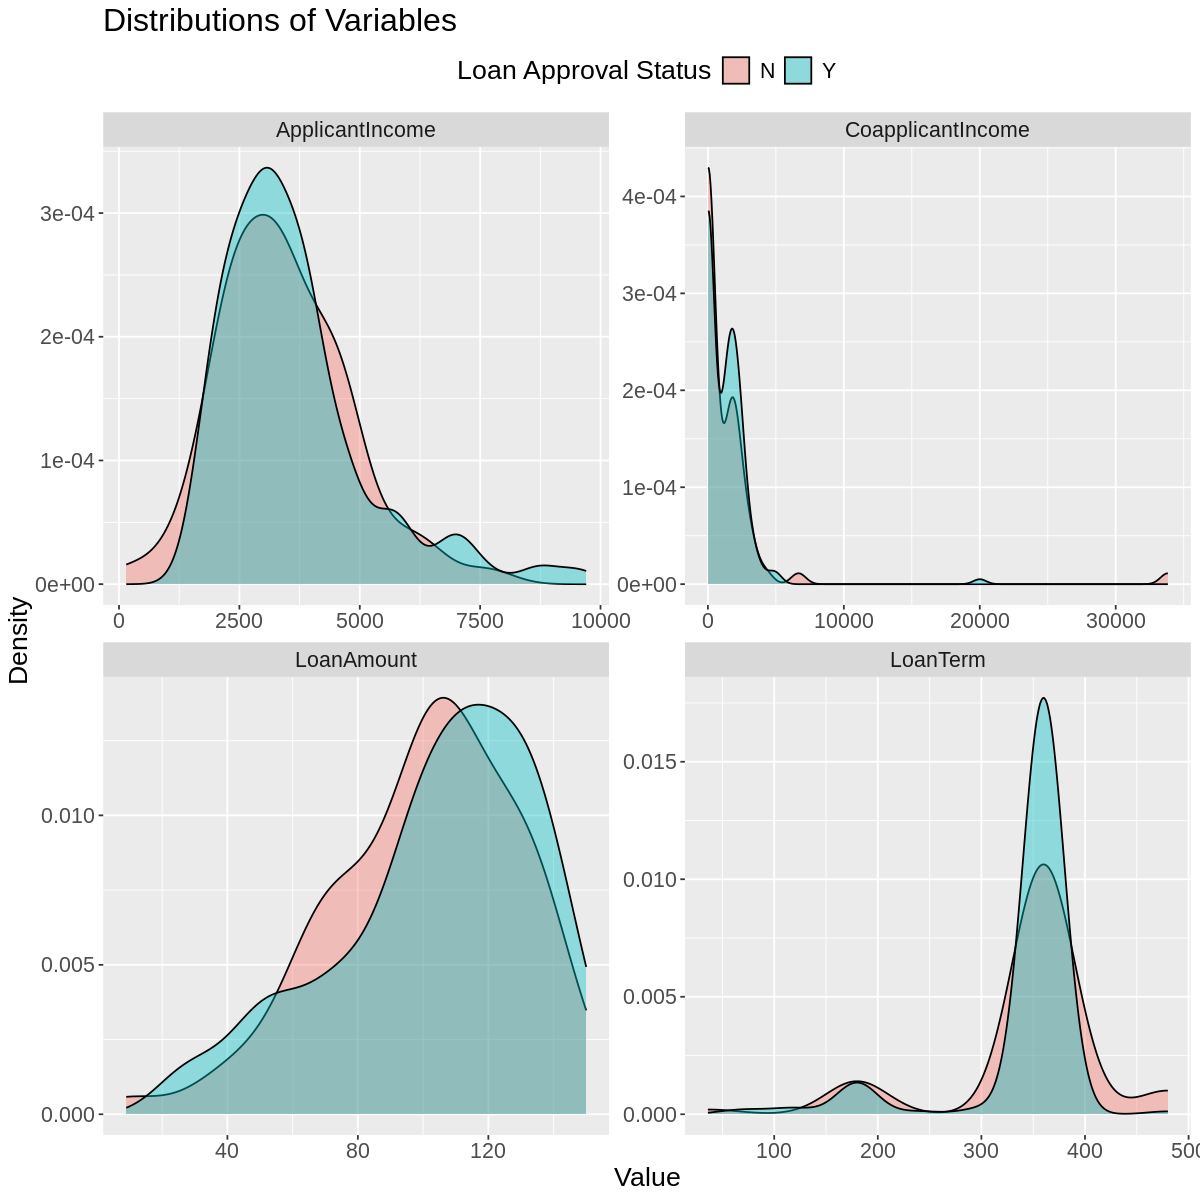

In [12]:
options(repr.plot.width=10, repr.plot.height=10)

distribution_plot <- loan_train |>
    pivot_longer(cols = c(ApplicantIncome, CoapplicantIncome, LoanAmount, LoanTerm), names_to = "category", values_to = "value") |>
    ggplot(aes(x = value, fill = LoanStatus)) +
        geom_density(alpha = 0.4) +
        facet_wrap(facets = vars(category), scales = "free") +
        labs(title = "Distributions of Variables",
             x = "Value", y = "Density", fill = "Loan Approval Status") +
        theme(text = element_text(size = 16), legend.position = "top")
distribution_plot

*<p><center> Figure 4.1: Distributions of potential predictors</center></p>*

As seen in Figure 4.1, there is a visible difference in distributions for the positive and negative classes. In the `ApplicantIncome` and `LoanTerm` variables, there is a clear lower peak in the distrubition for the negative class. This aligns with expectations, since an applicant with lower income and shorter loan repayment duration is at a higher risk of defaulting on the loan and is thus less likely to receive one. The `LoanAmount` variable has a similar peak, but is shifted (different center). These distinct differences in the distributions between positive/negative classes indicate that they would serve as effective predictor variables. By contrast, the differences in distribution for the `CoapplicantIncome` variable is less obvious, indicating that it could not be as strong of an indicator as the others, which again aligns with expectations.

#### 4.2. Relationship between Income and Loan Amount

**Relationship Analysis:** To prepare for the KNN classification, it is necessary to explore the relationship between predictor variables and the response variable. The scatter plot `relationship_plot` should better demonstrate the relationship between `ApplicantIncome`, `LoanAmount` and `LoanStatus`. `ApplicantIncome` and `LoanAmount` are the two most obvious starting points as they are the most significant factors taken into consideration when applying for a loan.

In [13]:
options(repr.plot.width=10, repr.plot.height=8)
relationship_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, y=ApplicantIncome, color=LoanStatus)) +
    geom_point() + 
    labs(title = "Relationship between Applicant Income, Loan Amount, and Loan Approval", x="Loan Amount ($)", y="Applicant Income ($)", color="Loan approved?") +
    theme(text = element_text(size = 16))

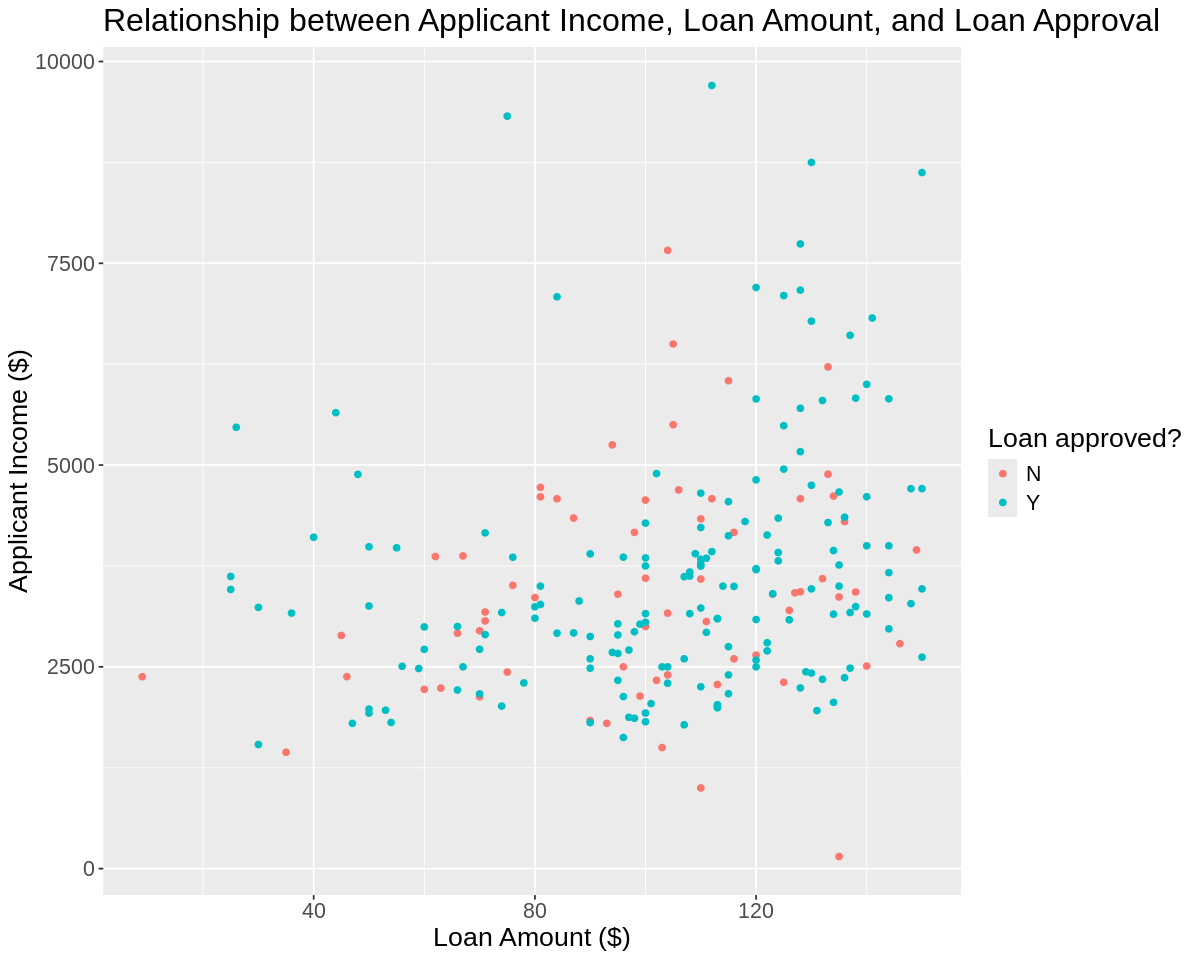

In [14]:
relationship_plot

*<p><center> Figure 4.2: Income V.S Loan Amount Graph </center></p>*

As seen in Figure 4.2, there does not seem to be any clear grouping occuring between the positive and negative classes. This indicates that the relationship between variables and loan outcome is more complex than just these two variables and that other predictors are needed for our model to be effective.

#### 5. Predictors Selection and Data Analysis from Visualization

 This project aims to use the following variables as predictors:
 - `ApplicantIncome`: Monthly income in dollars for the main applicant
 - `CoapplicantIncome`: Monthly income in dollars for any co-applicants in the main applicant's household
 - `LoanAmount`: Loan amount in thousands of dollars
 - `LoanTerm`: Loan term in months

 *TODO* explain why we chose these predictors

Through the preliminary data analysis phase, we have identified the following issues that need to be addressed:

**1.** There are more than twice as many positive `LoanStatus` class occurrences as negative ones. This will lead to a class imbalance that affects the classifier's performance. To solve this, we will be upsampling the the negative class

**2.** There is also a class imbalance on the `ApplicantIncome` variable. Based on the density plot in Figure 4.1, the negative class and positive classes dominate at the extreme low and extreme high ends of income respectively. This imbalance might lead to poor classification in these outlier areas since the all the neighbours used in the KNN will be dominated by one class. Hence, this model might not be as effective in predicting the loan status of individuals with very high and very low incomes. This is partially mitigated by the fact that the other predictor variables we are using do not suffer from the same magnitude of imbalance. This will help to offset the lack of data points in `ApplicantIncome` at the affected regions.

## Creating the model ($K$-nearest neighbours)

Since this is a classification problem, we will be using a $K$-nearest neighbors (KNN) model.
To create our model, the following steps will be taken:

1. Create a recipe that predicts `LoanStatus`, with `ApplicantIncome, CoapplicantIncome, LoanAmount, LoanTerm` as predictors.
2. Create a specification that uses k-nearest neighbors, with neighbors = tune() to select the best `K` value.
3. Split the data into 10 folds to perform cross-validation.
4. Create a workflow to train the classifier with `tune_grid()`.

### 1. Dealing with class imbalance

As seen in the summary table presented previously, the positive class (LoanStatus == Y) appears significantly (~48%) more than the negative class. This imbalance could lead to poor performance of the classifier. When building the model,the negative class will be upsampled by using ```step_upsample()``` as part of the recipe. It is important to set ```skip = TRUE``` to ensure that the upsampling is done only on the training data.

The predictors were also centered and scaled to ensure they have equal impact on the classifier.

In [15]:
loan_recipe <- recipe(LoanStatus ~ ApplicantIncome + CoapplicantIncome + LoanAmount +  LoanTerm, data = loan_train) |>
    step_upsample(LoanStatus, skip = TRUE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

### 2. Tuning the model

In [16]:
# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross valdiation
loan_vfold <- vfold_cv(loan_train, v = 10, strata = LoanStatus)

# K value in range [0, 100]
gridvals <- tibble(neighbors = c(1:100))

# Create workflow
knn_results <- workflow() |>
      add_recipe(loan_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = loan_vfold, grid = gridvals) |>
# Collect metrics, filter for accuracy
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

### 3. Choosing a $K$ value

After performing the cross-fold validation and tuning the classifier, we need to select the optimal $K$ value. We will select this value by plotting the accuracy obtained versus the number of neighbours.

In [17]:
head(knn_results)

neighbors,mean
<int>,<dbl>
31,0.6453887
32,0.6453887
29,0.6444499
30,0.6444499
39,0.6400856
40,0.6400856


*<p><center> Figure 5.2: Results of Training </center></p>*

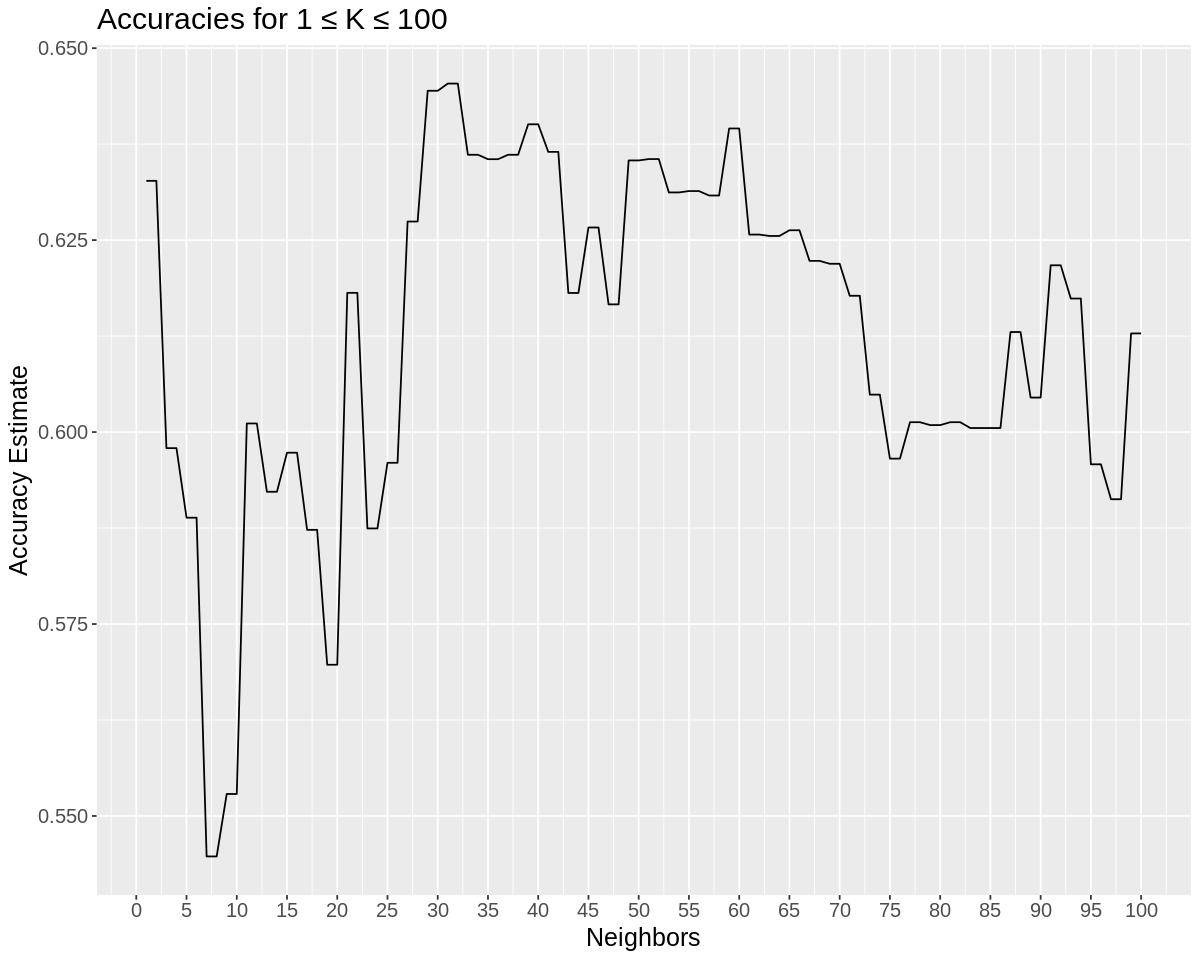

In [18]:
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ K ≤ 100") +
      scale_x_continuous(breaks = seq(0, 100, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k

*<p><center> Figure 5.3: K Value Accuracy</center></p>*

As seen in Figure 5.2 and 5.3, there is a distinct peak in accuracy for $K = 31$. The accuracy of the classifier generally decreases for larger values of $K$. $K = 31$ is also sufficiently large enough that it indicates that the classifier is less likely to be overfit as individual points have a lower ability to impact the outcome. Hence, we will use $K = 31$ when training our final classifier.

### 4. Building the final model

Using the parameter values obtained in the classifier tuning stage, we will train the final model. The `final_spec` uses `neighbors = 31` as determined by our findings.

In [19]:
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 31) |>
    set_engine("kknn") |>
    set_mode("classification")

loan_fit <- workflow() |>
    add_recipe(loan_recipe) |>
    add_model(final_spec) |>
    fit(data = loan_train)

### 5. Testing the final model

Now that the final model is trained, we will evaluate it on "unseen" data to determine it's final accuracy. This is done by using the `predict()` function and uses the `loan_test` data we defined earlier. We use the `metrics()` function to determine the overall accuracy of the classifier and use `conf_mat()` to create a confusion matrix that identifies the areas of weakness in the classifier.

In [20]:
#predict LoanStatus using loan_test data
predictions <- predict(loan_fit, loan_test) %>%
               bind_cols(loan_test)

metrics <- predictions |>
    metrics(truth = LoanStatus, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat <- predictions |>
    conf_mat(truth = LoanStatus, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6282051


          Truth
Prediction  N  Y
         N  8 14
         Y 15 41

*<p><center> Figure 5.5: Final Prediction Accuracy </center></p>*

As seen in Figure 5.5, the classifier had an overall accuracy of $62.82$%. With the data from the confusion matrix we calculate the following values:

$Precision = \frac{41}{41 + 15} * 100  = 73.21$%

$Recall = \frac{41}{41 + 14} * 100 = 74.55$%


Futhermore, we also calculate the False positive rate (FPR) with the following equation $FPR = \frac{FP}{FP + TN}$.

$FPR = \frac{15}{15 + 8} * 100 = 65.22$%

## Discussion

### Discussion of Results

From the results above, our classifier predicts the correct loan approval status $62.82$% of the time. This is lower than a majority classifier that has an accuracy of $\frac{41 + 14}{41 + 14 + 8 + 15} = 70.51$%. Even though the model has a relatively acceptable precision and recall numbers, the model has a high false positive rate of $65.22$%. 

In a loan-approval context, this is especially damaging as a non-approved loan being wrongly classified as an approved loan has larger consequences than a false negative since it can do long term damage to credit scores. Based on these numbers, we can conclude that $K$-nearest neighbours is not an effective classifier for this task.

These results strongly suggest that the predictor variables used are insufficient to establish a relationship with loan-approval status. The original dataset comes with other variables such as marital status, number of dependants, education level, property ownership, credit history approval etc. However, these are categorical variables that cannot be easily used in the $K$-nearest neighbours algorithm without using non-Euclidean distance functions.

This suggests that a more robust classifier such as decision trees or logistic regression is needed to capture the complex relationship between both categorical and continuous variables that affect loan outcomes and could be an area of future work.

### Impact and significance

Intuitively, the average person might consider loan amount, loan term and total income as the most important factors influencing the outcome of a loan application. However, with our results, we have demonstrated that these predictors alone do not perform well and other factors are needed. While the average person can easily determine their total income, other factors like debt to earnings ratio, credit score etc. being used by banks to determine loan approval might be harder to calculate. 

This highlights a gap in the understanding of how loan approvals work, and banks could use this information to build tools for customers to key in their details and get a reasonable estimate of the approval chances. This reduces uncertainty for the customer and creates a smoother experience.

### Future Questions

1) Would other classifier algorithms perform better when given both the categorical and continuous variables available as predictors?
2) Is it possible to determine the most significant factor that affects loan approval status?
3) As false positives are more damaging, is it possible to incentivise the classifier to reduce the false positive rate rather than just overall accuracy?

## References

*TODO*